In [1]:
# Imports
import os
import json
import tqdm
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

In [2]:
# Load all results and args into this dictionary

#model_names = ['WRS2810-40-HL', 'WRS2810-40-SL', 'WRS2810-250-HL', 'WRS2810-250-SL', 'WRS2810-4000-HL', 'WRS2810-4000-SL']
model_names = ['WRS2810-40-HL', 'WRS2810-40-SL', 'WRS2810-250-HL', 'WRS2810-250-SL']
root_path = Path('../../../results/ssl/')

results = {mn:{} for mn in model_names}

for model_name in model_names:
    paths = sorted(list(root_path.glob(model_name+"*")))
    for path in tqdm.tqdm(paths):
        with open(path / 'results.json', 'r') as f:
            run_results = json.load(f)
        with open(path / '.hydra/config.yaml') as g:
            conf = yaml.load(g, Loader=yaml.FullLoader)

        results[model_name][path.stem[-1]] = {'results': run_results, 'args': conf}

100%|██████████| 8/8 [00:00<00:00, 93.97it/s]


In [3]:
metrics_to_be_evaluated = {
    'train_history' : ['train_acc1', 'train_total_loss', 'train_unsup_loss', 'train_mask_ratio'],
    'test_history' : ['test_acc1', 'test_loss']
}

metrics_single = {}
metrics_mean = {}
metrics_std = {}


for model_name in model_names:
    metrics_single[model_name] = {}
    metrics_mean[model_name] = {}
    metrics_std[model_name] = {}
    for history, metrics in metrics_to_be_evaluated.items():
        for metric in metrics:
            metrics_single[model_name][metric] = {}
            metric_values_all = []
            for seed, run_results in results[model_name].items():
                metric_values = []
                for iteration in run_results['results'][history]:
                    metric_values.append(iteration[metric])
                metrics_single[model_name][metric][seed] = metric_values
                metric_values_all.append(metric_values)
            metrics_mean[model_name][metric] = np.mean(np.array(metric_values_all), axis=0)
            metrics_std[model_name][metric] = np.std(np.array(metric_values_all), axis=0)

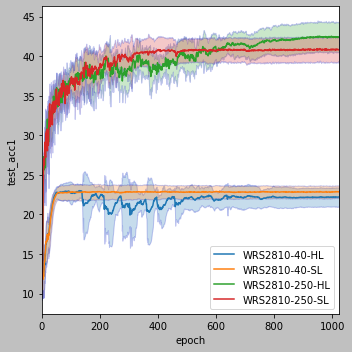

In [4]:
# Choice of Demonstration for test stats
metric = 'test_acc1'
show_std = True

fig = plt.figure(figsize=(5,5), facecolor='silver', edgecolor='black', tight_layout=True)

for model, label in zip(model_names, model_names):
    plt.plot(metrics_mean[model][metric], label=label)
    if show_std:
        plt.fill_between(
            x=[i for i in range(len(metrics_mean[model][metric]))], 
            y1=metrics_mean[model][metric]+abs(metrics_std[model][metric]), 
            y2=metrics_mean[model][metric]-abs(metrics_std[model][metric]),
            alpha=0.25,
            edgecolor='#1B2ACC', 
            )
plt.legend(loc='lower right')
plt.xlim(0, len(metrics_mean[model][metric])-1)
plt.xlabel('epoch')
plt.ylabel(metric)
plt.show()

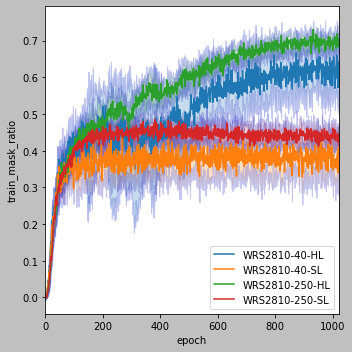

In [5]:
# Choice of Demonstration for test stats
metric = 'train_mask_ratio'
show_std = True

fig = plt.figure(figsize=(5,5), facecolor='silver', edgecolor='black', tight_layout=True)

for model, label in zip(model_names, model_names):
    plt.plot(metrics_mean[model][metric], label=label)
    if show_std:
        plt.fill_between(
            x=[i for i in range(len(metrics_mean[model][metric]))], 
            y1=metrics_mean[model][metric]+abs(metrics_std[model][metric]), 
            y2=metrics_mean[model][metric]-abs(metrics_std[model][metric]),
            alpha=0.25,
            edgecolor='#1B2ACC', 
            )
plt.legend(loc='lower right')
plt.xlim(0, len(metrics_mean[model][metric])-1)
plt.xlabel('epoch')
plt.ylabel(metric)
plt.show()

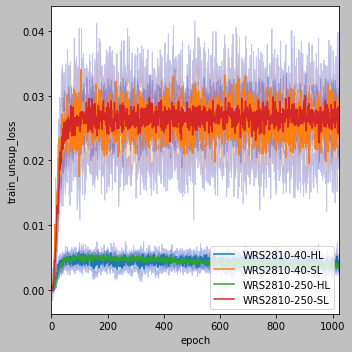

In [6]:
# Choice of Demonstration for test stats
metric = 'train_unsup_loss'
show_std = True

fig = plt.figure(figsize=(5,5), facecolor='silver', edgecolor='black', tight_layout=True)

for model, label in zip(model_names, model_names):
    plt.plot(metrics_mean[model][metric], label=label)
    if show_std:
        plt.fill_between(
            x=[i for i in range(len(metrics_mean[model][metric]))], 
            y1=metrics_mean[model][metric]+abs(metrics_std[model][metric]), 
            y2=metrics_mean[model][metric]-abs(metrics_std[model][metric]),
            alpha=0.25,
            edgecolor='#1B2ACC', 
            )
plt.legend(loc='lower right')
plt.xlim(0, len(metrics_mean[model][metric])-1)
plt.xlabel('epoch')
plt.ylabel(metric)
plt.show()

In [7]:
# BestAcc Table
best_accs_mean = {}
best_accs_std = {}
for model_name in model_names:
    best_model_accs = []
    for seed, run_results in results[model_name].items():
        test_history = run_results['results']['test_history']
        best_model_accs.append(max([stats['test_acc1'] for stats in test_history]))
    best_accs_mean[model_name] = np.mean(np.array(best_model_accs))
    best_accs_std[model_name] = np.std(np.array(best_model_accs))

best_accs = {
    model_name : str(100 - np.round(best_accs_mean[model_name], 2))+"+/-"+str(np.round(best_accs_std[model_name], 2)) for model_name in model_names
}

pd.DataFrame([best_accs])

,WRS2810-40-HL,WRS2810-40-SL,WRS2810-250-HL,WRS2810-250-SL
0,75.93+/-0.89,76.8+/-0.86,57.06+/-1.75,58.67+/-1.49
